In [1]:
import keras
keras.__version__
import tensorflow as tf
tf.__version__
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

from keras.applications.resnet50 import ResNet50


In [3]:
os.listdir('dataset')

['Affected Images', 'Normal Images']

In [4]:
def assign_label(img,label):
    return label

In [5]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
X=[]
Z=[]
IMG_SIZE=150
NOCAN ='dataset\\Normal Images'
CAN='dataset\\Affected Images'

make_train_data('DISE',NOCAN)
make_train_data('NDISE',CAN)

100%|███████████████████████████████████████████████████████████████████████████████| 977/977 [00:06<00:00, 149.11it/s]


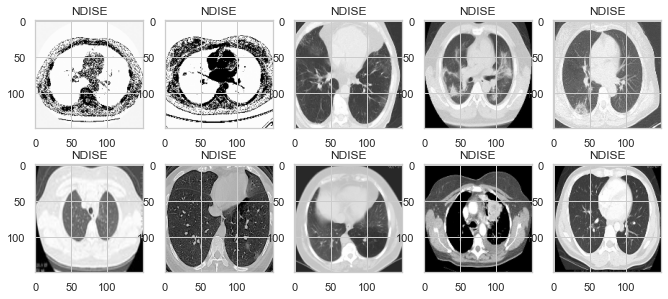

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3,top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [8]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)
#X=X/255

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)
#tf.set_random_seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
# base_model=vgg16(include_top=False, weights='imagenet',input_shape=(150,150,3), pooling='max')
 
from keras.applications import VGG16
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(150,150,3), pooling='max')
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0    

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [11]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
epochs=100
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 18,389,314
Trainable params: 18,389,314
Non-trainable params: 0
__________________________________________

In [12]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))


Train on 804 samples, validate on 268 samples
Epoch 1/100
804/804 [==============================] - 388s 482ms/step - loss: 0.8250 - accuracy: 0.8856 - val_loss: 0.3707 - val_accuracy: 0.8433
Epoch 2/100
804/804 [==============================] - 388s 483ms/step - loss: 0.2506 - accuracy: 0.8930 - val_loss: 0.2323 - val_accuracy: 0.8769
Epoch 3/100
804/804 [==============================] - 390s 485ms/step - loss: 0.1892 - accuracy: 0.9117 - val_loss: 0.2247 - val_accuracy: 0.8769
Epoch 4/100
804/804 [==============================] - 391s 486ms/step - loss: 0.1705 - accuracy: 0.9104 - val_loss: 0.2126 - val_accuracy: 0.8731
Epoch 5/100
804/804 [==============================] - 374s 465ms/step - loss: 0.1425 - accuracy: 0.9129 - val_loss: 0.2473 - val_accuracy: 0.8470
Epoch 6/100
804/804 [==============================] - 386s 480ms/step - loss: 0.1400 - accuracy: 0.9279 - val_loss: 0.2393 - val_accuracy: 0.8545
Epoch 7/100
804/804 [==============================] - 391s 486ms/step 

Epoch 55/100
804/804 [==============================] - 407s 507ms/step - loss: 0.0683 - accuracy: 0.9614 - val_loss: 0.5303 - val_accuracy: 0.8619
Epoch 56/100
804/804 [==============================] - 394s 490ms/step - loss: 0.0786 - accuracy: 0.9590 - val_loss: 0.3611 - val_accuracy: 0.8358
Epoch 57/100
804/804 [==============================] - 391s 486ms/step - loss: 0.0712 - accuracy: 0.9590 - val_loss: 0.5431 - val_accuracy: 0.8470
Epoch 58/100
804/804 [==============================] - 411s 511ms/step - loss: 0.0737 - accuracy: 0.9540 - val_loss: 0.5007 - val_accuracy: 0.8619
Epoch 59/100
804/804 [==============================] - 389s 484ms/step - loss: 0.0722 - accuracy: 0.9565 - val_loss: 0.4180 - val_accuracy: 0.8619
Epoch 60/100
804/804 [==============================] - 383s 476ms/step - loss: 0.0701 - accuracy: 0.9614 - val_loss: 0.5290 - val_accuracy: 0.8545
Epoch 61/100
804/804 [==============================] - 393s 489ms/step - loss: 0.0625 - accuracy: 0.9664 - val_

In [13]:
model.save('vgg16model.h5')

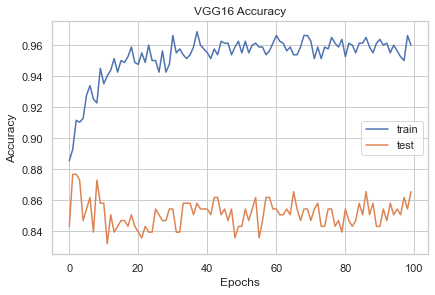

In [14]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('VGG16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

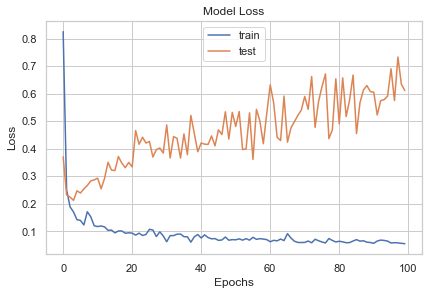

In [15]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
path="dataset\\Normal Images\\"
files=os.listdir(path)
for i in files:
    X=cv2.imread(path+i)
    X=cv2.resize(X,(150,150))
#     plt.figure()
#     plt.imshow(X[:,:,::-1]) 
#     plt.show()  # display it


    X = np.array(X)
   # X = X/255
    X = np.expand_dims(X, axis=0)

    print(np.round(model.predict(X)))

[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]
[[1. 0.]]


In [17]:
path="dataset\\Affected Images\\"
files=os.listdir(path)
for i in files:
    X=cv2.imread(path+i)
    X=cv2.resize(X,(150,150))
#     plt.figure()
#     plt.imshow(X[:,:,::-1]) 
#     plt.show()  # display it


    X = np.array(X)
   # X = X/255

    X = np.expand_dims(X, axis=0)

    print(np.round(model.predict(X)))

[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]


[[1. 0.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[1. 0.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]
[[0. 1.]]


In [18]:
#calculate loss and accuracy on test data

tLoss, tAccuracy = model.evaluate(x_test, y_test)

print('Test accuracy: {:2.2f}%'.format(tAccuracy*100))

268/268 [==============================] - 46s 173ms/step
Test accuracy: 86.57%
